In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder


# Read in Data

In [21]:
lstn = pd.read_csv('../data/prepped_training.csv')

In [93]:
# The code below will aggregate the correlation coefficients between all columns which are not
#  price and log_price vs. price and log price

# This code using dictionaries was written with the help of the following sourece:
#  https://www.guru99.com/python-dictionary-append.html
corr_dict = {'name': [], 'price_corr':[], 'log_price_corr': [], 'magnitude': [], 'which': []}

# Get a list of all the columns to iterate through, remvoe price and log_price
col_list = list(lstn.columns)
col_list.remove('price')
col_list.remove('log_price')

# This loop creates data for each column
for col in col_list:
    
    # Find correlations to price and log_price
    p_corr = np.corrcoef(lstn[col], lstn['price'])[0][1]
    lp_corr = np.corrcoef(lstn[col], lstn['log_price'])[0][1]
    
    # Repor the higher magnitude value
    mag = max(abs(p_corr), abs(lp_corr))
    
    # Append the above data to the dictionary
    corr_dict['name'].append(col)
    corr_dict['price_corr'].append(p_corr)
    corr_dict['log_price_corr'].append(lp_corr)
    corr_dict['magnitude'].append(mag)
    
    # The if statement below will print which correaltion is stronger
    if abs(p_corr) > abs(lp_corr):
        corr_dict['which'].append('price')
    
    else:
        corr_dict['which'].append('log_price')

# Create a dataframe from the dictionary
corr_df = pd.DataFrame(corr_dict)

# Set the index to be the column names collected as there is no need for a numerical index
corr_df.set_index('name', inplace=True)
corr_df.head()

,price_corr,log_price_corr,magnitude,which
name,,,,
host_since,0.039550,0.027396,0.039550,price
host_response_rate,-0.003495,0.041759,0.041759,log_price
host_acceptance_rate,0.130797,0.271477,0.271477,log_price
host_listings_count,0.016601,0.136672,0.136672,log_price
host_total_listings_count,-0.011012,0.082024,0.082024,log_price


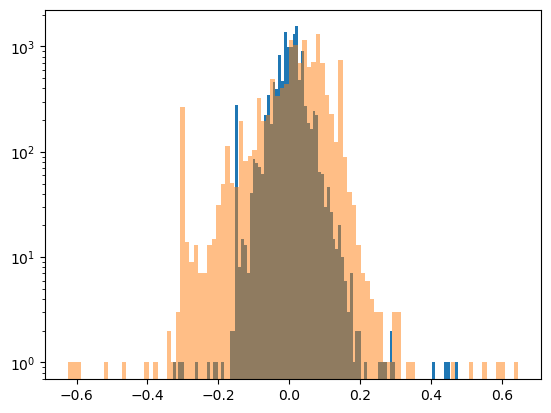

In [94]:
# Plot an overlapping histogram of the correlation distributions
plt.hist(corr_df.price_corr, bins = 100)
plt.hist(corr_df.log_price_corr, bins = 100, alpha = 0.5)
plt.yscale('log')
plt.show();

In [99]:
# Create a dataframe sorted by the correlation magnitude
corr_df_sorted = corr_df.sort_values(by = 'magnitude', ascending=False)

# Create an empty list to store the column names
best_columns = []

# Create an index to loop through
bc_index = 0

# Write a while loop to get the top 30 most highly correlated columns which are
#  not already duplicated in the list with either their log or non-log counterparts
while len(best_columns) < 30:
    
    # simplify the name of the individual column names pulled out of the df index
    next_column = corr_df_sorted.index[bc_index]
    
    # If the log version not is already there, and if the non-log version of the colunm
    #  name are not already there, then add the column name
    if f'log_{next_column}' not in best_columns and next_column.replace('log_', '') not in best_columns:
        best_columns.append(next_column)
    
    # Increase the index value by 1
    bc_index += 1

In [100]:
# View the most highly correlated variables above in the correlation dataframe
corr_df_sorted.loc[best_columns]

,price_corr,log_price_corr,magnitude,which
name,,,,
log_accommodates,0.437727,0.647343,0.647343,log_price
room_type_Private room,-0.328703,-0.625225,0.625225,log_price
pcnt_private,-0.310895,-0.605388,0.605388,log_price
pcnt_ent_homes,0.292924,0.598974,0.598974,log_price
property_type_Private room in rental unit,-0.258554,-0.519602,0.519602,log_price
log_beds,0.405373,0.516437,0.516437,log_price
log_calculated_host_listings_count_private_rooms,-0.226114,-0.462623,0.462623,log_price
bathrooms_text_1 shared bath,-0.207068,-0.397327,0.397327,log_price
amen_Lock on bedroom door,-0.208319,-0.381361,0.381361,log_price


In [103]:
# Filter the original training data with only the columns above:
lstn_best = lstn[best_columns]

# Append the log_price column
lstn_best['log_price'] = lstn.log_price

lstn_best.head()

C:\Users\Dan\AppData\Local\Temp\ipykernel_18932\2672393132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstn_best['log_price'] = lstn.log_price


,log_accommodates,room_type_Private room,pcnt_private,pcnt_ent_homes,property_type_Private room in rental unit,log_beds,log_calculated_host_listings_count_private_rooms,bathrooms_text_1 shared bath,amen_Lock on bedroom door,description_shared,...,host_about_experience of,log_bedrooms,description_space br about,description_the space br about,description_this home br br,description_space br about this,description_about this home br,description_br about this home,host_about_to rent,log_price
0,1.609438,0.0,0.000,1.000,0.0,0.693147,0.000000,0.0,0,0,...,0,0.693147,0,0,0,0,0,0,0,5.484797
1,1.386294,0.0,0.000,1.000,0.0,0.693147,0.000000,0.0,0,1,...,0,0.000000,0,0,0,0,0,0,0,5.669881
2,0.000000,1.0,1.000,0.000,1.0,0.000000,3.433987,0.0,1,1,...,0,0.000000,0,0,0,0,0,0,0,3.583519
3,0.693147,1.0,0.982,0.018,1.0,0.000000,5.613128,0.0,0,1,...,1,1.386294,1,1,1,1,1,1,1,4.290459
4,2.772589,0.0,0.000,1.000,0.0,1.609438,0.000000,0.0,0,0,...,0,1.386294,0,0,0,0,0,0,0,6.656727


<Axes: >

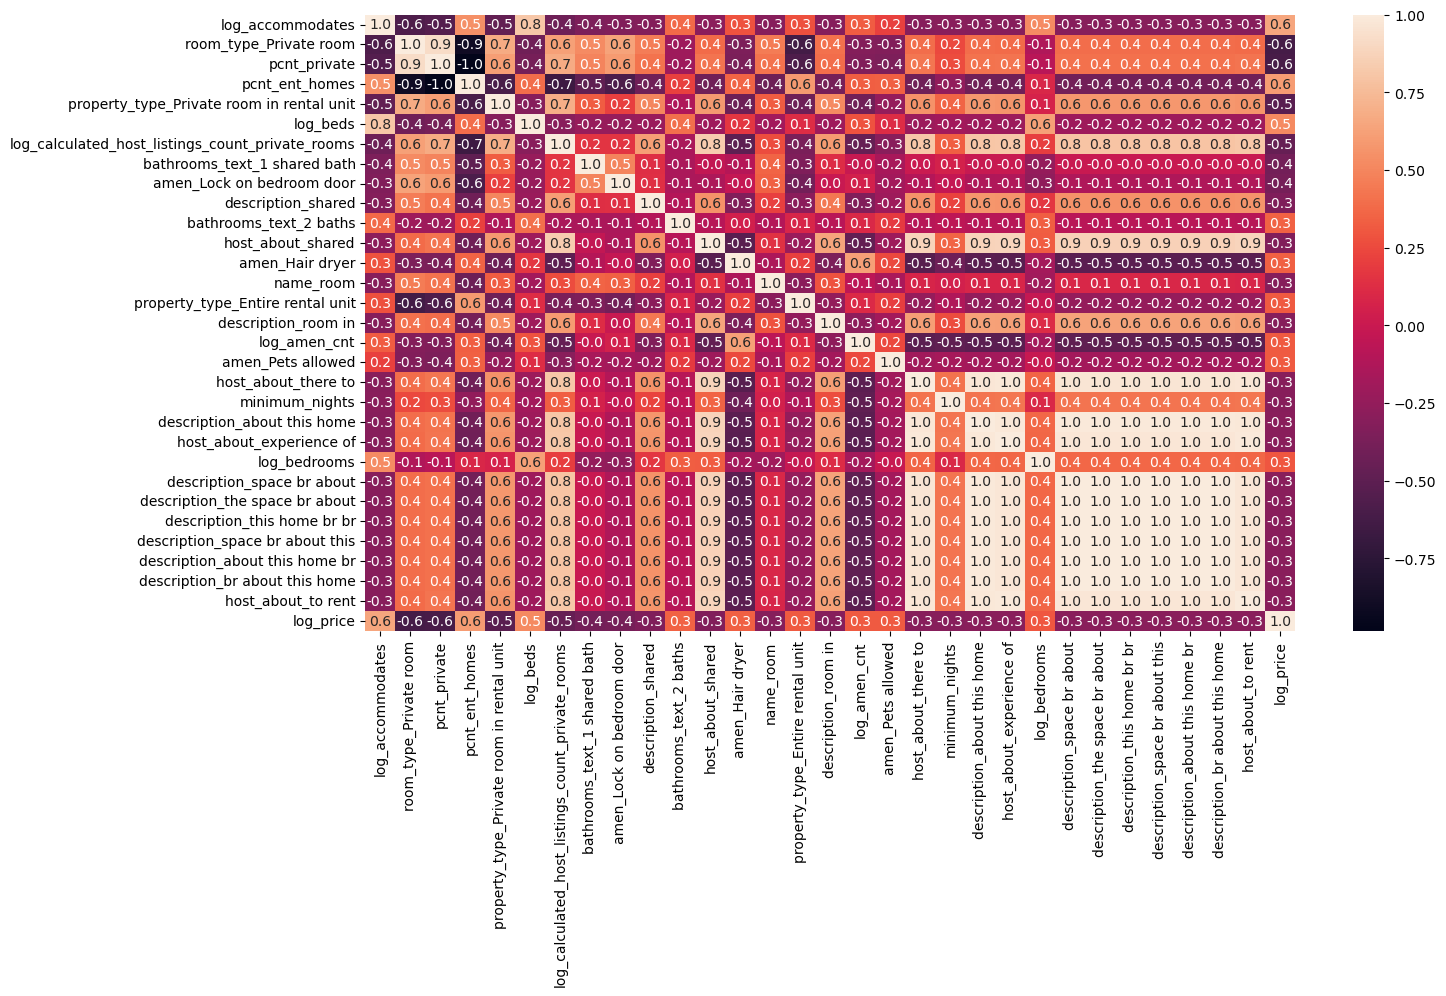

In [111]:
plt.figure(figsize = (15, 8))
sns.heatmap(lstn_best.corr(), annot = True, fmt='.1f')